In [1]:
# Melakukan impor libraries yang diperlukan untuk membangun model dan prediksi data.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
import optuna
from optuna.samplers import TPESampler
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import random
import time
import datetime

In [2]:
# Mencatat waktu dimulainya keseluruhan program model dan prediksi data.
global_start_time = time.time()

In [3]:
# Menetapkan nilai seed untuk reproduksi model.
seed = 2021
def set_seed(seed = seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)

set_seed()

In [4]:
# Menentukan indeks fold, kode penamaan program, banyak epoch, dan ukuran batch.
fold_index = 4
codename = '1_04_01_{}'.format(fold_index)
epochs = 128
batch_size = 64

In [5]:
# Menyusun data training.
df_train = pd.read_csv('../input/bdc-sd2021-train-tabular-data/train_gray.csv')
fake_train = pd.DataFrame(np.array(df_train).reshape((2305, 128, 128))[:, :, ::-1].reshape((2305, 128*128)))
fake_train.columns = df_train.columns
df_train = pd.concat([df_train, fake_train], ignore_index = True)
del fake_train

# Menyusun data testing.
df_test = pd.read_csv('../input/bdc-sd2021-test-tabular-data/test_gray.csv')

In [6]:
# Melakukan normalisasi pada data training.
scaler = MinMaxScaler(copy = False)
scaler.fit_transform(df_train.T)
df_train

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.183857,0.139013,0.098655,0.116592,0.121076,0.103139,0.116592,0.094170,0.089686,0.076233,...,0.242152,0.089686,0.103139,0.121076,0.134529,0.156951,0.156951,0.156951,0.174888,0.152466
1,0.857868,0.857868,0.857868,0.857868,0.857868,0.857868,0.842640,0.827411,0.842640,0.827411,...,0.319797,0.294416,0.253807,0.208122,0.147208,0.116751,0.096447,0.065990,0.055838,0.040609
2,0.018182,0.013636,0.013636,0.018182,0.018182,0.018182,0.018182,0.018182,0.013636,0.018182,...,0.568182,0.559091,0.536364,0.518182,0.486364,0.436364,0.368182,0.254545,0.113636,0.045455
3,0.162500,0.162500,0.154167,0.154167,0.166667,0.187500,0.216667,0.254167,0.233333,0.183333,...,0.666667,0.675000,0.745833,0.887500,0.908333,0.900000,0.916667,0.945833,0.966667,0.966667
4,0.893023,0.860465,0.804651,0.879070,0.869767,0.637209,0.479070,0.269767,0.186047,0.186047,...,0.106977,0.032558,0.027907,0.018605,0.004651,0.000000,0.000000,0.004651,0.009302,0.018605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.090476,0.076190,0.095238,0.114286,0.090476,0.109524,0.076190,0.061905,0.052381,0.076190,...,0.157143,0.114286,0.133333,0.047619,0.061905,0.061905,0.052381,0.042857,0.042857,0.042857
4606,0.356828,0.370044,0.396476,0.409692,0.396476,0.422907,0.471366,0.515419,0.480176,0.436123,...,0.030837,0.035242,0.030837,0.026432,0.022026,0.017621,0.039648,0.026432,0.017621,0.035242
4607,0.306977,0.279070,0.339535,0.330233,0.320930,0.367442,0.367442,0.316279,0.283721,0.339535,...,0.060465,0.074419,0.065116,0.051163,0.051163,0.046512,0.083721,0.065116,0.055814,0.097674
4608,0.145000,0.240000,0.290000,0.295000,0.230000,0.170000,0.185000,0.200000,0.200000,0.230000,...,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.010000,0.010000,0.010000


In [7]:
# Melakukan normalisasi pada data testing.
scaler.fit_transform(df_test.T)
df_test

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.095238,0.100000,0.100000,0.095238,0.095238,0.100000,0.109524,0.114286,0.119048,0.104762,...,0.347619,0.361905,0.314286,0.400000,0.419048,0.261905,0.233333,0.300000,0.266667,0.257143
1,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.066116,0.066116,...,0.417355,0.322314,0.285124,0.471074,0.508264,0.475207,0.541322,0.644628,0.611570,0.512397
2,0.531120,0.493776,0.485477,0.427386,0.402490,0.356846,0.340249,0.356846,0.336100,0.340249,...,0.190871,0.112033,0.062241,0.058091,0.074689,0.066390,0.058091,0.053942,0.045643,0.053942
3,0.796703,0.796703,0.791209,0.791209,0.796703,0.818681,0.818681,0.785714,0.763736,0.763736,...,0.961538,0.950549,0.950549,0.945055,0.939560,0.928571,0.923077,0.917582,0.906593,0.879121
4,0.222222,0.232804,0.232804,0.248677,0.253968,0.259259,0.248677,0.243386,0.243386,0.243386,...,0.619048,0.613757,0.608466,0.608466,0.613757,0.592593,0.566138,0.502646,0.470899,0.449735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.828571,0.844898,0.804082,0.824490,0.918367,0.963265,0.987755,0.959184,0.873469,0.722449,...,0.857143,0.848980,0.828571,0.832653,0.840816,0.840816,0.816327,0.820408,0.783673,0.767347
986,0.048780,0.065041,0.077236,0.105691,0.117886,0.121951,0.126016,0.069106,0.060976,0.052846,...,0.186992,0.207317,0.223577,0.239837,0.260163,0.284553,0.304878,0.321138,0.337398,0.357724
987,0.056872,0.056872,0.061611,0.061611,0.071090,0.056872,0.037915,0.023697,0.009479,0.018957,...,0.900474,0.890995,0.895735,0.900474,0.895735,0.895735,0.890995,0.890995,0.890995,0.890995
988,0.109244,0.155462,0.168067,0.121849,0.113445,0.088235,0.079832,0.084034,0.079832,0.067227,...,0.525210,0.281513,0.050420,0.033613,0.037815,0.033613,0.033613,0.042017,0.042017,0.042017


In [8]:
# Memunculkan target prediksi.
target_0 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_target_and_fold.csv')[['usia', 'fold']]
target_1 = pd.concat([target_0 for iteration in range(2)], ignore_index = True)
target_1

,usia,fold
0,27,3
1,27,3
2,27,3
3,24,0
4,24,0
...,...,...
4605,23,4
4606,23,4
4607,27,4
4608,27,4


In [9]:
# Melakukan penambahan data training yang berkaitan dengan posisi relatif fitur pada wajah.
df_train_1 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_facial_relative.csv')
fake_train_1 = df_train_1.copy()
fake_train_1['x_le'] = 1 - df_train_1['x_re']
fake_train_1['x_re'] = 1 - df_train_1['x_le']
fake_train_1['x_n'] = 1 - df_train_1['x_n']
fake_train_1['x_ml'] = 1 - df_train_1['x_mr']
fake_train_1['x_mr'] = 1 - df_train_1['x_ml']
fake_train_1[['sym_le_n', 'adj_le_n', 'sym_re_n', 'adj_re_n']] = df_train_1[['sym_re_n', 'adj_re_n', 'sym_le_n', 'adj_le_n']]
fake_train_1[['sym_le_ml', 'adj_le_ml', 'sym_re_mr', 'adj_re_mr']] = df_train_1[['sym_re_mr', 'adj_re_mr', 'sym_le_ml', 'adj_le_ml']]
fake_train_1[['sym_le_mr', 'adj_le_mr', 'sym_re_ml', 'adj_re_ml']] = df_train_1[['sym_re_ml', 'adj_re_ml', 'sym_le_mr', 'adj_le_mr']]
fake_train_1[['sym_n_ml', 'adj_n_ml', 'sym_n_mr', 'adj_n_mr']] = df_train_1[['sym_n_mr', 'adj_n_mr', 'sym_n_ml', 'adj_n_ml']]

df_train_1 = pd.concat([df_train_1, fake_train_1], ignore_index = True)
del fake_train_1

df_train_1

,x_le,y_le,x_re,y_re,x_n,y_n,x_ml,y_ml,x_mr,y_mr,...,adj_n_ml,sym_le_mr,adj_le_mr,sym_re_mr,adj_re_mr,sym_n_mr,adj_n_mr,sym_ml_mr,adj_ml_mr,abs_angle
0,0.204545,0.390411,0.698052,0.392694,0.405844,0.618721,0.194805,0.712329,0.733766,0.705479,...,0.249515,0.615908,0.693416,0.314818,0.446237,0.339205,0.350364,0.539005,0.539049,0.061566
1,0.179724,0.397351,0.589862,0.403974,0.290323,0.619205,0.202765,0.725166,0.635945,0.728477,...,0.171500,0.563722,0.648461,0.327759,0.453958,0.362484,0.377599,0.433192,0.433204,0.134023
2,0.195946,0.404878,0.662162,0.404878,0.378378,0.614634,0.202703,0.731707,0.682432,0.731707,...,0.239078,0.586077,0.664537,0.327457,0.453156,0.325814,0.344595,0.479730,0.479730,0.174672
3,0.266055,0.373239,0.715596,0.373239,0.440367,0.549296,0.238532,0.690141,0.724771,0.704225,...,0.272772,0.565660,0.629561,0.331113,0.431290,0.323865,0.348745,0.486442,0.486585,0.121842
4,0.244565,0.389764,0.695652,0.393701,0.413043,0.578740,0.217391,0.696850,0.706522,0.712598,...,0.254682,0.563583,0.641880,0.319083,0.440352,0.322564,0.346806,0.489384,0.489613,0.012195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.362934,0.401146,0.803089,0.383954,0.660232,0.616046,0.389961,0.759312,0.737452,0.753582,...,0.327708,0.530242,0.629355,0.364131,0.487068,0.162752,0.207921,0.347538,0.347576,0.540420
4606,0.232323,0.386256,0.744108,0.398104,0.515152,0.649289,0.313131,0.772512,0.717172,0.779621,...,0.274054,0.612584,0.719783,0.387194,0.549482,0.236635,0.267332,0.404103,0.404167,0.552494
4607,0.274869,0.400372,0.759162,0.396648,0.523560,0.616387,0.324607,0.780261,0.685864,0.780261,...,0.304386,0.562206,0.678031,0.386895,0.539038,0.230645,0.281800,0.361257,0.361257,0.162489
4608,0.323887,0.405836,0.801619,0.413793,0.668016,0.631300,0.425101,0.801061,0.785425,0.814324,...,0.370196,0.602490,0.749939,0.395557,0.603456,0.206407,0.284469,0.360568,0.360892,0.456213


In [10]:
# Melakukan penambahan data testing yang berkaitan dengan posisi relatif fitur pada wajah.
df_test_1 = pd.read_csv('../input/bdc-sd2021-data-tambahan/test_facial_relative.csv')
df_test_1

,x_le,y_le,x_re,y_re,x_n,y_n,x_ml,y_ml,x_mr,y_mr,...,adj_n_ml,sym_le_mr,adj_le_mr,sym_re_mr,adj_re_mr,sym_n_mr,adj_n_mr,sym_ml_mr,adj_ml_mr,abs_angle
0,0.291209,0.333333,0.758242,0.338028,0.521978,0.516432,0.296703,0.732394,0.730769,0.737089,...,0.338570,0.596852,0.645365,0.400006,0.467840,0.303782,0.332088,0.434091,0.434101,0.070471
1,0.281690,0.405128,0.753521,0.394872,0.549296,0.625641,0.260563,0.723077,0.746479,0.707692,...,0.318229,0.554593,0.623428,0.312900,0.429635,0.213573,0.227106,0.486159,0.486375,0.029403
2,0.214533,0.403023,0.660900,0.397985,0.366782,0.612091,0.235294,0.727960,0.692042,0.722922,...,0.206456,0.574761,0.648943,0.326426,0.447452,0.343624,0.359129,0.456775,0.456800,0.022553
3,0.365517,0.391753,0.779310,0.402062,0.648276,0.597938,0.393103,0.773196,0.758621,0.757732,...,0.346547,0.537095,0.627927,0.356271,0.476312,0.194191,0.240590,0.365844,0.366102,0.064427
4,0.265625,0.381323,0.734375,0.369650,0.500000,0.603113,0.296875,0.747082,0.718750,0.735409,...,0.279993,0.575064,0.655712,0.366092,0.489833,0.255644,0.281443,0.422036,0.422164,0.044914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.356364,0.398892,0.821818,0.398892,0.650909,0.617729,0.374545,0.739612,0.785455,0.736842,...,0.319338,0.546195,0.617197,0.339901,0.445124,0.179696,0.206282,0.410918,0.410925,0.124355
986,0.274725,0.380952,0.758242,0.373016,0.582418,0.563492,0.362637,0.777778,0.747253,0.753968,...,0.369237,0.602016,0.700027,0.381111,0.527587,0.251896,0.311010,0.385352,0.386026,0.047583
987,0.289855,0.373737,0.753623,0.383838,0.521739,0.585859,0.275362,0.737374,0.724638,0.747475,...,0.328573,0.573337,0.690348,0.364790,0.522544,0.259399,0.308120,0.449389,0.449509,0.031240
988,0.142857,0.338403,0.614286,0.338403,0.319048,0.593156,0.200000,0.779468,0.557143,0.779468,...,0.261948,0.605120,0.690476,0.444751,0.555329,0.302327,0.333367,0.357143,0.357143,0.020199


In [11]:
# Menyusun indeks untuk data training dan melakukan shuffle.
train_index = list(target_1[target_1['fold'] != fold_index].index)
random.seed(seed)
random.shuffle(train_index)

# Menyusun indeks untuk data validasi.
valid_index = list(target_0[target_0['fold'] == fold_index].index)

# Memisahkan data validasi dari data training, serta menginisiasi data testing.
X_train = df_train.iloc[train_index]
X_valid = df_train.iloc[valid_index]
X_test = df_test.copy()

X_train_1 = df_train_1.iloc[train_index]
X_valid_1 = df_train_1.iloc[valid_index]
X_test_1 = df_test_1.copy()

# Melakukan reduksi dimensi dengan menggunakan PCA.
pca = PCA(0.95)
X_train = pd.DataFrame(pca.fit_transform(X_train))
X_valid = pd.DataFrame(pca.transform(X_valid))
X_test = pd.DataFrame(pca.transform(X_test))

pca = PCA(0.95)
X_train_1 = pd.DataFrame(pca.fit_transform(X_train_1))
X_valid_1 = pd.DataFrame(pca.transform(X_valid_1))
X_test_1 = pd.DataFrame(pca.transform(X_test_1))

# Menggabungkan informasi pada data training, validasi, dan testing.
X_train = pd.concat([X_train, X_train_1], axis = 1, ignore_index = True)
X_valid = pd.concat([X_valid, X_valid_1], axis = 1, ignore_index = True)
X_test = pd.concat([X_test, X_test_1], axis = 1, ignore_index = True)
del X_train_1, X_valid_1, X_test_1

# Mengubah ukuran data agar sesuai dengan input yang diharapkan oleh model.
X_train = X_train.values.reshape(-1, X_train.shape[1], 1).astype('float64')
X_valid = X_valid.values.reshape(-1, X_valid.shape[1], 1).astype('float64')
X_test = X_test.values.reshape(-1, X_test.shape[1], 1).astype('float64')

# Memisahkan target validasi dari target training.
y_train = target_1.iloc[train_index, 0].astype('int64')
y_valid = target_0.iloc[valid_index, 0].astype('int64')

# Membuang informasi yang sudah tidak diperlukan lagi.
del df_train, df_test, df_train_1, df_test_1, pca, target_0, target_1, train_index, valid_index

In [12]:
# Mendefinisikan fungsi untuk mencari parameter terbaik dengan nilai error terkecil.
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 5)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3, log = True)
    dropout = trial.suggest_float('dropout', 0.2, 0.5, log = True)
    model = Sequential()
    for i in range(n_layers-1):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 32, 256, log = True)
        if i:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(weight_decay)))
            model.add(Dropout(dropout))
        else:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(weight_decay),
                            input_shape = (X_train.shape[1], 1)))
    model.add(Flatten())
    num_hidden = trial.suggest_int('n_units_l{}'.format(n_layers-1), 32, 256, log = True)
    model.add(Dense(num_hidden,
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(1,
                    activation = 'linear',
                    kernel_regularizer = regularizers.l2(weight_decay)))
    return model

def create_optimizer(trial):
    kwargs = {}
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer_selected == 'RMSprop':
        kwargs['learning_rate'] = trial.suggest_float(
            'rmsprop_learning_rate', 1e-5, 1e-1, log=True)
        kwargs['decay'] = trial.suggest_float('rmsprop_decay', 0.85, 0.99)
        kwargs['momentum'] = trial.suggest_float('rmsprop_momentum', 1e-5, 1e-1, log = True)
    elif optimizer_selected == 'Adam':
        kwargs['learning_rate'] = trial.suggest_float('adam_learning_rate', 1e-5, 1e-1, log = True)
    elif optimizer_selected == 'SGD':
        kwargs['learning_rate'] = trial.suggest_float(
            'sgd_opt_learning_rate', 1e-5, 1e-1, log=True)
        kwargs['momentum'] = trial.suggest_float('sgd_opt_momentum', 1e-5, 1e-1, log = True)
    
    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def objective(trial):
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    set_seed()
    history = model.fit(X_train, y_train,
                        epochs = 3,
                        validation_data = (X_valid, y_valid),
                        verbose = 2,
                        steps_per_epoch = X_train.shape[0] // batch_size)
    y_valid_pred = model.predict(X_valid)
    try:
        mse = MSE(y_valid, y_valid_pred)
    except ValueError:
        mse = 1e+32
    return mse

In [13]:
# Mencari hyperparameters terbaik.
try:
    study = optuna.create_study(sampler = TPESampler(seed = seed), direction = 'minimize')
    study.optimize(objective, n_trials = 50)
except ValueError:
    pass

[I 2021-11-04 11:17:37,917] A new study created in memory with name: no-name-a699da5d-093c-42c1-b1d9-40097259c2af

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIN

Epoch 1/3
57/57 - 5s - loss: 633.0663 - mse: 633.0626 - val_loss: 423.2720 - val_mse: 423.2684
Epoch 2/3
57/57 - 4s - loss: 120.2883 - mse: 120.2846 - val_loss: 38.1303 - val_mse: 38.1266
Epoch 3/3
57/57 - 4s - loss: 39.3495 - mse: 39.3459 - val_loss: 36.5853 - val_mse: 36.5817


[I 2021-11-04 11:17:52,156] Trial 0 finished with value: 36.581661718924174 and parameters: {'n_layers': 4, 'weight_decay': 1.3601459990500093e-05, 'dropout': 0.22715517141780636, 'n_units_l0': 61, 'n_units_l1': 255, 'n_units_l2': 41, 'n_units_l3': 46, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 2.4410551066709827e-05, 'sgd_opt_momentum': 1.7150829926878746e-05}. Best is trial 0 with value: 36.581661718924174.


Epoch 1/3
57/57 - 9s - loss: 251.9698 - mse: 251.9687 - val_loss: 38.7188 - val_mse: 38.7177
Epoch 2/3
57/57 - 8s - loss: 36.3567 - mse: 36.3555 - val_loss: 34.3333 - val_mse: 34.3322
Epoch 3/3
57/57 - 8s - loss: 33.6728 - mse: 33.6717 - val_loss: 33.7200 - val_mse: 33.7189


[I 2021-11-04 11:18:18,520] Trial 1 finished with value: 33.718889093820216 and parameters: {'n_layers': 5, 'weight_decay': 2.069674778352553e-06, 'dropout': 0.2165227444547113, 'n_units_l0': 102, 'n_units_l1': 115, 'n_units_l2': 238, 'n_units_l3': 105, 'n_units_l4': 69, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 6.0309245793449296e-05, 'sgd_opt_momentum': 0.0021618027516387694}. Best is trial 1 with value: 33.718889093820216.


Epoch 1/3
57/57 - 3s - loss: 76.3069 - mse: 76.3067 - val_loss: 32.4126 - val_mse: 32.4124
Epoch 2/3
57/57 - 2s - loss: 31.0909 - mse: 31.0907 - val_loss: 28.0694 - val_mse: 28.0692
Epoch 3/3
57/57 - 2s - loss: 27.6167 - mse: 27.6165 - val_loss: 26.3750 - val_mse: 26.3748


[I 2021-11-04 11:18:25,148] Trial 2 finished with value: 26.374758439445124 and parameters: {'n_layers': 3, 'weight_decay': 4.2140608469491625e-07, 'dropout': 0.425181023662834, 'n_units_l0': 146, 'n_units_l1': 36, 'n_units_l2': 129, 'optimizer': 'Adam', 'adam_learning_rate': 0.0029509089780652155}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 7s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/3
57/57 - 5s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/3
57/57 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan


[I 2021-11-04 11:18:43,621] Trial 3 finished with value: 1e+32 and parameters: {'n_layers': 4, 'weight_decay': 1.280797128821542e-08, 'dropout': 0.4445600696908863, 'n_units_l0': 108, 'n_units_l1': 247, 'n_units_l2': 80, 'n_units_l3': 41, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.006855869932485577, 'sgd_opt_momentum': 0.03652763447965056}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 4s - loss: 156.4897 - mse: 156.4890 - val_loss: 34.5119 - val_mse: 34.5111
Epoch 2/3
57/57 - 3s - loss: 35.3158 - mse: 35.3151 - val_loss: 35.4509 - val_mse: 35.4502
Epoch 3/3
57/57 - 3s - loss: 32.8426 - mse: 32.8419 - val_loss: 34.4051 - val_mse: 34.4044


[I 2021-11-04 11:18:53,018] Trial 4 finished with value: 34.404367085396274 and parameters: {'n_layers': 4, 'weight_decay': 2.869521426120942e-06, 'dropout': 0.2736582989224417, 'n_units_l0': 177, 'n_units_l1': 60, 'n_units_l2': 60, 'n_units_l3': 48, 'optimizer': 'Adam', 'adam_learning_rate': 0.0003587550277569686}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 5s - loss: nan - mse: 419666629454752382976.0000 - val_loss: nan - val_mse: 648533602065186816.0000
Epoch 2/3
57/57 - 4s - loss: nan - mse: 211725102960607232.0000 - val_loss: nan - val_mse: 32312136331952128.0000
Epoch 3/3
57/57 - 4s - loss: nan - mse: 10548864880738304.0000 - val_loss: nan - val_mse: 1609901784694784.0000


[I 2021-11-04 11:19:06,409] Trial 5 finished with value: 1609901508388816.8 and parameters: {'n_layers': 4, 'weight_decay': 8.671491605192508e-05, 'dropout': 0.2120474687506201, 'n_units_l0': 75, 'n_units_l1': 63, 'n_units_l2': 143, 'n_units_l3': 85, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.012820573397259222, 'sgd_opt_momentum': 0.01219735525440408}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 1s - loss: 97.0365 - mse: 97.0363 - val_loss: 54.1349 - val_mse: 54.1347
Epoch 2/3
57/57 - 1s - loss: 47.3804 - mse: 47.3802 - val_loss: 44.6320 - val_mse: 44.6317
Epoch 3/3
57/57 - 1s - loss: 42.8413 - mse: 42.8411 - val_loss: 42.2050 - val_mse: 42.2048


[I 2021-11-04 11:19:09,590] Trial 6 finished with value: 42.204781424136364 and parameters: {'n_layers': 2, 'weight_decay': 1.4490033299339797e-06, 'dropout': 0.4134236878013778, 'n_units_l0': 56, 'n_units_l1': 69, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0004666904757351211, 'rmsprop_decay': 0.894925822839254, 'rmsprop_momentum': 0.000308450498248823}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 4s - loss: 77616.0156 - mse: 77616.0078 - val_loss: 136.9178 - val_mse: 136.8997
Epoch 2/3
57/57 - 3s - loss: 149.6192 - mse: 149.6012 - val_loss: 81.4131 - val_mse: 81.3951
Epoch 3/3
57/57 - 3s - loss: 97.8162 - mse: 97.7982 - val_loss: 63.0253 - val_mse: 63.0073


[I 2021-11-04 11:19:20,293] Trial 7 finished with value: 63.007279737831354 and parameters: {'n_layers': 3, 'weight_decay': 5.713328696681321e-06, 'dropout': 0.3407865362809055, 'n_units_l0': 241, 'n_units_l1': 75, 'n_units_l2': 63, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019638650422524002, 'rmsprop_decay': 0.9279674621367233, 'rmsprop_momentum': 0.007481765717358807}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 6s - loss: 622727.6875 - mse: 622727.6875 - val_loss: 202.0018 - val_mse: 202.0011
Epoch 2/3
57/57 - 4s - loss: 111.8049 - mse: 111.8041 - val_loss: 475.3471 - val_mse: 475.3464
Epoch 3/3
57/57 - 5s - loss: 50.5679 - mse: 50.5672 - val_loss: 488.6379 - val_mse: 488.6372


[I 2021-11-04 11:19:35,501] Trial 8 finished with value: 488.6372295429754 and parameters: {'n_layers': 5, 'weight_decay': 2.9653117862224153e-07, 'dropout': 0.3197493177048565, 'n_units_l0': 123, 'n_units_l1': 65, 'n_units_l2': 116, 'n_units_l3': 83, 'n_units_l4': 41, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019054962911205356, 'rmsprop_decay': 0.874518227528278, 'rmsprop_momentum': 8.371297680962848e-05}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 10s - loss: 3528.1794 - mse: 3528.1575 - val_loss: 50.9783 - val_mse: 50.9565
Epoch 2/3
57/57 - 8s - loss: 47.0429 - mse: 47.0211 - val_loss: 53.0614 - val_mse: 53.0397
Epoch 3/3
57/57 - 8s - loss: 43.2505 - mse: 43.2287 - val_loss: 54.3623 - val_mse: 54.3406


[I 2021-11-04 11:20:02,309] Trial 9 finished with value: 54.34057723670597 and parameters: {'n_layers': 4, 'weight_decay': 1.0556840099451229e-05, 'dropout': 0.22909938508654398, 'n_units_l0': 72, 'n_units_l1': 170, 'n_units_l2': 172, 'n_units_l3': 167, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.005553572385099785, 'rmsprop_decay': 0.9526963318618572, 'rmsprop_momentum': 3.908613352528237e-05}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 1s - loss: 2651.7964 - mse: 2651.7959 - val_loss: 645.8014 - val_mse: 645.8004
Epoch 2/3
57/57 - 0s - loss: 593.9340 - mse: 593.9332 - val_loss: 530.5504 - val_mse: 530.5494
Epoch 3/3
57/57 - 0s - loss: 478.9574 - mse: 478.9565 - val_loss: 419.4459 - val_mse: 419.4449


[I 2021-11-04 11:20:04,540] Trial 10 finished with value: 419.4448749969969 and parameters: {'n_layers': 2, 'weight_decay': 1.5303673965817338e-08, 'dropout': 0.36337622618058174, 'n_units_l0': 37, 'n_units_l1': 38, 'optimizer': 'Adam', 'adam_learning_rate': 0.07687620678695332}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 17s - loss: 1741.5437 - mse: 1730.6243 - val_loss: 708.3187 - val_mse: 695.5170
Epoch 2/3
57/57 - 15s - loss: 621.5485 - mse: 610.1604 - val_loss: 50.0997 - val_mse: 39.9072
Epoch 3/3
57/57 - 15s - loss: 51.1550 - mse: 41.7234 - val_loss: 36.7664 - val_mse: 28.0641


[I 2021-11-04 11:20:51,946] Trial 11 finished with value: 28.064075186117652 and parameters: {'n_layers': 5, 'weight_decay': 0.0008338016434700748, 'dropout': 0.4953827096246268, 'n_units_l0': 141, 'n_units_l1': 121, 'n_units_l2': 253, 'n_units_l3': 245, 'n_units_l4': 142, 'optimizer': 'Adam', 'adam_learning_rate': 0.008983185806335612}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 69.0866 - mse: 67.7805 - val_loss: 29.9669 - val_mse: 28.5090
Epoch 2/3
57/57 - 2s - loss: 30.5986 - mse: 29.3141 - val_loss: 27.5928 - val_mse: 26.4545
Epoch 3/3
57/57 - 2s - loss: 28.6677 - mse: 27.6209 - val_loss: 27.4053 - val_mse: 26.4304


[I 2021-11-04 11:20:59,982] Trial 12 finished with value: 26.430374796768394 and parameters: {'n_layers': 3, 'weight_decay': 0.000695990869779388, 'dropout': 0.4909028434074908, 'n_units_l0': 158, 'n_units_l1': 35, 'n_units_l2': 249, 'optimizer': 'Adam', 'adam_learning_rate': 0.00755110127673275}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 84.2675 - mse: 84.2675 - val_loss: 35.1400 - val_mse: 35.1400
Epoch 2/3
57/57 - 2s - loss: 30.7250 - mse: 30.7250 - val_loss: 27.3384 - val_mse: 27.3384
Epoch 3/3
57/57 - 2s - loss: 27.7823 - mse: 27.7823 - val_loss: 27.6865 - val_mse: 27.6865


[I 2021-11-04 11:21:07,211] Trial 13 finished with value: 27.686546985339973 and parameters: {'n_layers': 3, 'weight_decay': 2.2300489272818375e-10, 'dropout': 0.40489818215472173, 'n_units_l0': 200, 'n_units_l1': 32, 'n_units_l2': 165, 'optimizer': 'Adam', 'adam_learning_rate': 0.002256391950997491}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 576.9658 - mse: 576.7397 - val_loss: 404.4454 - val_mse: 404.2225
Epoch 2/3
57/57 - 2s - loss: 228.4543 - mse: 228.2314 - val_loss: 85.0826 - val_mse: 84.8588
Epoch 3/3
57/57 - 2s - loss: 46.5541 - mse: 46.3298 - val_loss: 37.2993 - val_mse: 37.0760


[I 2021-11-04 11:21:14,641] Trial 14 finished with value: 37.075993382273175 and parameters: {'n_layers': 3, 'weight_decay': 0.0008460518118904421, 'dropout': 0.49891172563768604, 'n_units_l0': 155, 'n_units_l1': 44, 'n_units_l2': 101, 'optimizer': 'Adam', 'adam_learning_rate': 3.9698593450778636e-05}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 798.9248 - mse: 798.9248 - val_loss: 685.8885 - val_mse: 685.8885
Epoch 2/3
57/57 - 2s - loss: 677.7903 - mse: 677.7903 - val_loss: 660.4584 - val_mse: 660.4584
Epoch 3/3
57/57 - 2s - loss: 652.3948 - mse: 652.3948 - val_loss: 635.3107 - val_mse: 635.3107


[I 2021-11-04 11:21:22,038] Trial 15 finished with value: 635.3107436694863 and parameters: {'n_layers': 2, 'weight_decay': 1.2523296495552792e-10, 'dropout': 0.28322315406943344, 'n_units_l0': 253, 'n_units_l1': 44, 'optimizer': 'Adam', 'adam_learning_rate': 0.009265002534502789}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 114.9969 - mse: 114.9969 - val_loss: 35.8719 - val_mse: 35.8719
Epoch 2/3
57/57 - 2s - loss: 35.3110 - mse: 35.3109 - val_loss: 32.2432 - val_mse: 32.2432
Epoch 3/3
57/57 - 2s - loss: 30.9225 - mse: 30.9224 - val_loss: 28.8977 - val_mse: 28.8976


[I 2021-11-04 11:21:29,173] Trial 16 finished with value: 28.897634844047957 and parameters: {'n_layers': 3, 'weight_decay': 7.827150280044339e-08, 'dropout': 0.4453922187570523, 'n_units_l0': 184, 'n_units_l1': 32, 'n_units_l2': 174, 'optimizer': 'Adam', 'adam_learning_rate': 0.0006915371023089415}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 396.0681 - mse: 396.0680 - val_loss: 28.9750 - val_mse: 28.9750
Epoch 2/3
57/57 - 2s - loss: 30.0115 - mse: 30.0115 - val_loss: 27.5041 - val_mse: 27.5041
Epoch 3/3
57/57 - 2s - loss: 28.8732 - mse: 28.8732 - val_loss: 27.6855 - val_mse: 27.6855


[I 2021-11-04 11:21:36,447] Trial 17 finished with value: 27.685455142604326 and parameters: {'n_layers': 3, 'weight_decay': 1.2647114680295807e-09, 'dropout': 0.3722776920199142, 'n_units_l0': 126, 'n_units_l1': 51, 'n_units_l2': 125, 'optimizer': 'Adam', 'adam_learning_rate': 0.023137522991638158}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 2s - loss: 65.4740 - mse: 65.4502 - val_loss: 35.1333 - val_mse: 35.1063
Epoch 2/3
57/57 - 1s - loss: 32.6411 - mse: 32.6134 - val_loss: 32.4848 - val_mse: 32.4564
Epoch 3/3
57/57 - 1s - loss: 29.7336 - mse: 29.7039 - val_loss: 32.8713 - val_mse: 32.8399


[I 2021-11-04 11:21:41,719] Trial 18 finished with value: 32.839933610532434 and parameters: {'n_layers': 2, 'weight_decay': 7.176689341498653e-05, 'dropout': 0.4493640425555687, 'n_units_l0': 89, 'n_units_l1': 92, 'optimizer': 'Adam', 'adam_learning_rate': 0.0020196915085595973}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 4s - loss: 271.8172 - mse: 271.7674 - val_loss: 40.3287 - val_mse: 40.2797
Epoch 2/3
57/57 - 3s - loss: 40.0191 - mse: 39.9715 - val_loss: 37.2018 - val_mse: 37.1554
Epoch 3/3
57/57 - 3s - loss: 37.4909 - mse: 37.4453 - val_loss: 36.0915 - val_mse: 36.0465


[I 2021-11-04 11:21:50,764] Trial 19 finished with value: 36.04652190349973 and parameters: {'n_layers': 3, 'weight_decay': 0.00010665309719852067, 'dropout': 0.39658396716973743, 'n_units_l0': 146, 'n_units_l1': 49, 'n_units_l2': 203, 'optimizer': 'Adam', 'adam_learning_rate': 8.228683129434993e-05}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 2s - loss: 60.7788 - mse: 60.7787 - val_loss: 34.3058 - val_mse: 34.3057
Epoch 2/3
57/57 - 2s - loss: 31.1681 - mse: 31.1680 - val_loss: 31.7325 - val_mse: 31.7324
Epoch 3/3
57/57 - 2s - loss: 26.1496 - mse: 26.1495 - val_loss: 27.9846 - val_mse: 27.9844


[I 2021-11-04 11:21:57,374] Trial 20 finished with value: 27.984441651073162 and parameters: {'n_layers': 2, 'weight_decay': 9.352375626608931e-08, 'dropout': 0.4679109144591078, 'n_units_l0': 210, 'n_units_l1': 38, 'optimizer': 'Adam', 'adam_learning_rate': 0.0046721409164871205}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 13633.0684 - mse: 13633.0674 - val_loss: 44.0804 - val_mse: 44.0802
Epoch 2/3
57/57 - 2s - loss: 29.8921 - mse: 29.8918 - val_loss: 26.7929 - val_mse: 26.7927
Epoch 3/3
57/57 - 2s - loss: 28.4866 - mse: 28.4864 - val_loss: 26.5889 - val_mse: 26.5887


[I 2021-11-04 11:22:04,973] Trial 21 finished with value: 26.588649877896827 and parameters: {'n_layers': 3, 'weight_decay': 1.557530282906504e-09, 'dropout': 0.36546046278136546, 'n_units_l0': 121, 'n_units_l1': 52, 'n_units_l2': 126, 'optimizer': 'Adam', 'adam_learning_rate': 0.05338672411053631}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 120882.6953 - mse: 120882.6953 - val_loss: 31.6508 - val_mse: 31.6501
Epoch 2/3
57/57 - 2s - loss: 31.7980 - mse: 31.7973 - val_loss: 28.5658 - val_mse: 28.5651
Epoch 3/3
57/57 - 2s - loss: 31.4077 - mse: 31.4071 - val_loss: 28.7813 - val_mse: 28.7807


[I 2021-11-04 11:22:11,487] Trial 22 finished with value: 28.780681187876112 and parameters: {'n_layers': 3, 'weight_decay': 2.9898984405395263e-09, 'dropout': 0.37138675358403056, 'n_units_l0': 157, 'n_units_l1': 38, 'n_units_l2': 96, 'optimizer': 'Adam', 'adam_learning_rate': 0.08947015920208075}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 241.2900 - mse: 241.2900 - val_loss: 27.5606 - val_mse: 27.5606
Epoch 2/3
57/57 - 2s - loss: 29.2475 - mse: 29.2474 - val_loss: 28.0363 - val_mse: 28.0363
Epoch 3/3
57/57 - 2s - loss: 29.5412 - mse: 29.5412 - val_loss: 27.9300 - val_mse: 27.9300


[I 2021-11-04 11:22:17,610] Trial 23 finished with value: 27.93001644485068 and parameters: {'n_layers': 3, 'weight_decay': 1.9071651958728947e-09, 'dropout': 0.4060961192919428, 'n_units_l0': 106, 'n_units_l1': 52, 'n_units_l2': 74, 'optimizer': 'Adam', 'adam_learning_rate': 0.02628636982215726}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 104.7585 - mse: 104.7526 - val_loss: 30.2980 - val_mse: 30.2902
Epoch 2/3
57/57 - 2s - loss: 29.7921 - mse: 29.7842 - val_loss: 26.4524 - val_mse: 26.4445
Epoch 3/3
57/57 - 2s - loss: 27.4160 - mse: 27.4081 - val_loss: 28.0287 - val_mse: 28.0208


[I 2021-11-04 11:22:23,744] Trial 24 finished with value: 28.020800108362987 and parameters: {'n_layers': 3, 'weight_decay': 5.03827677134389e-07, 'dropout': 0.3027471822665216, 'n_units_l0': 132, 'n_units_l1': 32, 'n_units_l2': 143, 'optimizer': 'Adam', 'adam_learning_rate': 0.024618914068465895}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 4s - loss: 164.1904 - mse: 164.1904 - val_loss: 38.7381 - val_mse: 38.7381
Epoch 2/3
57/57 - 2s - loss: 35.9266 - mse: 35.9266 - val_loss: 42.1463 - val_mse: 42.1463
Epoch 3/3
57/57 - 2s - loss: 33.6409 - mse: 33.6409 - val_loss: 39.2060 - val_mse: 39.2060


[I 2021-11-04 11:22:35,290] Trial 25 finished with value: 39.2060288422084 and parameters: {'n_layers': 4, 'weight_decay': 1.470122435251432e-08, 'dropout': 0.34275171306050045, 'n_units_l0': 88, 'n_units_l1': 39, 'n_units_l2': 38, 'n_units_l3': 134, 'optimizer': 'Adam', 'adam_learning_rate': 0.0003333092743992524}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 4s - loss: 67.8741 - mse: 67.8741 - val_loss: 30.3893 - val_mse: 30.3893
Epoch 2/3
57/57 - 3s - loss: 30.9548 - mse: 30.9548 - val_loss: 27.0868 - val_mse: 27.0868
Epoch 3/3
57/57 - 3s - loss: 26.2790 - mse: 26.2790 - val_loss: 26.4395 - val_mse: 26.4395


[I 2021-11-04 11:22:44,980] Trial 26 finished with value: 26.439539842449836 and parameters: {'n_layers': 3, 'weight_decay': 4.857220089692218e-10, 'dropout': 0.4242911742392825, 'n_units_l0': 116, 'n_units_l1': 87, 'n_units_l2': 118, 'optimizer': 'Adam', 'adam_learning_rate': 0.006659120362460368}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 84.7537 - mse: 84.7143 - val_loss: 38.2184 - val_mse: 38.1681
Epoch 2/3
57/57 - 2s - loss: 34.7380 - mse: 34.6876 - val_loss: 33.6550 - val_mse: 33.6044
Epoch 3/3
57/57 - 2s - loss: 30.4190 - mse: 30.3681 - val_loss: 32.9440 - val_mse: 32.8924


[I 2021-11-04 11:22:52,847] Trial 27 finished with value: 32.89235415802133 and parameters: {'n_layers': 2, 'weight_decay': 3.152315930407568e-05, 'dropout': 0.4249009765950843, 'n_units_l0': 164, 'n_units_l1': 85, 'optimizer': 'Adam', 'adam_learning_rate': 0.004354018666651356}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 7s - loss: 668.7691 - mse: 668.6030 - val_loss: 657.5712 - val_mse: 657.4050
Epoch 2/3
57/57 - 5s - loss: 659.4049 - mse: 659.2386 - val_loss: 653.4814 - val_mse: 653.3152
Epoch 3/3
57/57 - 5s - loss: 656.3730 - mse: 656.2067 - val_loss: 651.0964 - val_mse: 650.9302


[I 2021-11-04 11:23:10,524] Trial 28 finished with value: 650.9302033204244 and parameters: {'n_layers': 3, 'weight_decay': 0.00033996469375134706, 'dropout': 0.4758491627346887, 'n_units_l0': 34, 'n_units_l1': 158, 'n_units_l2': 216, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.010747326723815e-05, 'rmsprop_decay': 0.9677635539876915, 'rmsprop_momentum': 0.09792461029873681}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 6s - loss: nan - mse: 60528424588517925860407532194889728.0000 - val_loss: nan - val_mse: 78607396445831654799310848.0000
Epoch 2/3
57/57 - 5s - loss: nan - mse: 4391836569635412860993536.0000 - val_loss: nan - val_mse: 32607492642963456.0000
Epoch 3/3
57/57 - 5s - loss: nan - mse: 1821797620121600.0000 - val_loss: nan - val_mse: 13525365.0000


[I 2021-11-04 11:23:26,217] Trial 29 finished with value: 13525364.65596945 and parameters: {'n_layers': 4, 'weight_decay': 1.307987371528035e-07, 'dropout': 0.43665240435954916, 'n_units_l0': 52, 'n_units_l1': 110, 'n_units_l2': 194, 'n_units_l3': 32, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.08631186468037616, 'sgd_opt_momentum': 2.3566982169933773e-05}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 5s - loss: 72.9975 - mse: 72.9975 - val_loss: 35.7940 - val_mse: 35.7940
Epoch 2/3
57/57 - 4s - loss: 34.0120 - mse: 34.0120 - val_loss: 31.3286 - val_mse: 31.3286
Epoch 3/3
57/57 - 4s - loss: 31.0612 - mse: 31.0612 - val_loss: 29.1356 - val_mse: 29.1356


[I 2021-11-04 11:23:40,517] Trial 30 finished with value: 29.13559041461362 and parameters: {'n_layers': 2, 'weight_decay': 4.5670912929896083e-10, 'dropout': 0.46993192602228695, 'n_units_l0': 215, 'n_units_l1': 153, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0003959502675922957, 'sgd_opt_momentum': 0.000272368752504295}. Best is trial 2 with value: 26.374758439445124.


Epoch 1/3
57/57 - 3s - loss: 76.0293 - mse: 76.0293 - val_loss: 35.0460 - val_mse: 35.0460
Epoch 2/3
57/57 - 2s - loss: 28.9482 - mse: 28.9482 - val_loss: 25.7465 - val_mse: 25.7465
Epoch 3/3
57/57 - 2s - loss: 25.8438 - mse: 25.8438 - val_loss: 26.2318 - val_mse: 26.2318


[I 2021-11-04 11:23:48,035] Trial 31 finished with value: 26.231802294586906 and parameters: {'n_layers': 3, 'weight_decay': 5.669834146823962e-10, 'dropout': 0.39240857882334235, 'n_units_l0': 115, 'n_units_l1': 55, 'n_units_l2': 116, 'optimizer': 'Adam', 'adam_learning_rate': 0.009717723426427008}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 3s - loss: 61.1241 - mse: 61.1241 - val_loss: 27.6384 - val_mse: 27.6384
Epoch 2/3
57/57 - 2s - loss: 27.8255 - mse: 27.8255 - val_loss: 26.6828 - val_mse: 26.6828
Epoch 3/3
57/57 - 2s - loss: 25.5621 - mse: 25.5621 - val_loss: 26.9436 - val_mse: 26.9436


[I 2021-11-04 11:23:59,357] Trial 32 finished with value: 26.9435505969055 and parameters: {'n_layers': 3, 'weight_decay': 5.581384104066554e-09, 'dropout': 0.38567224680201134, 'n_units_l0': 98, 'n_units_l1': 59, 'n_units_l2': 110, 'optimizer': 'Adam', 'adam_learning_rate': 0.009494338135034364}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 2s - loss: 81.3663 - mse: 81.3663 - val_loss: 35.0937 - val_mse: 35.0937
Epoch 2/3
57/57 - 2s - loss: 31.5977 - mse: 31.5977 - val_loss: 27.9626 - val_mse: 27.9626
Epoch 3/3
57/57 - 1s - loss: 28.0749 - mse: 28.0749 - val_loss: 27.7383 - val_mse: 27.7383


[I 2021-11-04 11:24:05,831] Trial 33 finished with value: 27.738288374064943 and parameters: {'n_layers': 3, 'weight_decay': 4.2671133364188066e-10, 'dropout': 0.42935784141833955, 'n_units_l0': 119, 'n_units_l1': 44, 'n_units_l2': 88, 'optimizer': 'Adam', 'adam_learning_rate': 0.001976749222508456}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 4s - loss: 86.3639 - mse: 86.3639 - val_loss: 35.1081 - val_mse: 35.1081
Epoch 2/3
57/57 - 3s - loss: 31.0266 - mse: 31.0266 - val_loss: 27.3680 - val_mse: 27.3680
Epoch 3/3
57/57 - 3s - loss: 27.7523 - mse: 27.7523 - val_loss: 26.8864 - val_mse: 26.8864


[I 2021-11-04 11:24:14,847] Trial 34 finished with value: 26.886379402878774 and parameters: {'n_layers': 3, 'weight_decay': 5.187368305744276e-10, 'dropout': 0.4655227914607626, 'n_units_l0': 78, 'n_units_l1': 80, 'n_units_l2': 151, 'optimizer': 'Adam', 'adam_learning_rate': 0.0037160857052506604}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 8s - loss: 172.0108 - mse: 172.0108 - val_loss: 72.6538 - val_mse: 72.6537
Epoch 2/3
57/57 - 7s - loss: 51.8079 - mse: 51.8079 - val_loss: 33.8209 - val_mse: 33.8209
Epoch 3/3
57/57 - 7s - loss: 37.6792 - mse: 37.6791 - val_loss: 27.3657 - val_mse: 27.3657


[I 2021-11-04 11:24:37,795] Trial 35 finished with value: 27.36565557222244 and parameters: {'n_layers': 4, 'weight_decay': 4.9840095968703475e-08, 'dropout': 0.34589469667628986, 'n_units_l0': 107, 'n_units_l1': 102, 'n_units_l2': 134, 'n_units_l3': 246, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0007228525825965658, 'sgd_opt_momentum': 0.0003701279620216436}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 5s - loss: 83.9886 - mse: 83.9886 - val_loss: 32.5249 - val_mse: 32.5249
Epoch 2/3
57/57 - 4s - loss: 28.7380 - mse: 28.7380 - val_loss: 27.6827 - val_mse: 27.6827
Epoch 3/3
57/57 - 4s - loss: 27.4832 - mse: 27.4832 - val_loss: 26.7721 - val_mse: 26.7721


[I 2021-11-04 11:24:50,509] Trial 36 finished with value: 26.772104175630833 and parameters: {'n_layers': 4, 'weight_decay': 1.0963450390565562e-10, 'dropout': 0.24836751441050584, 'n_units_l0': 174, 'n_units_l1': 57, 'n_units_l2': 106, 'n_units_l3': 67, 'optimizer': 'Adam', 'adam_learning_rate': 0.010035986792807379}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 4s - loss: 615.5801 - mse: 615.5798 - val_loss: 474.7839 - val_mse: 474.7837
Epoch 2/3
57/57 - 3s - loss: 272.6410 - mse: 272.6407 - val_loss: 90.2864 - val_mse: 90.2861
Epoch 3/3
57/57 - 3s - loss: 54.9779 - mse: 54.9777 - val_loss: 44.7909 - val_mse: 44.7907


[I 2021-11-04 11:25:01,507] Trial 37 finished with value: 44.790662255369945 and parameters: {'n_layers': 3, 'weight_decay': 1.0480435309419643e-06, 'dropout': 0.4200821239188948, 'n_units_l0': 138, 'n_units_l1': 134, 'n_units_l2': 45, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.233524185497482e-05, 'sgd_opt_momentum': 0.08448435474832919}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 3s - loss: 86.2380 - mse: 86.2380 - val_loss: 35.7732 - val_mse: 35.7732
Epoch 2/3
57/57 - 2s - loss: 35.5127 - mse: 35.5127 - val_loss: 33.6998 - val_mse: 33.6998
Epoch 3/3
57/57 - 3s - loss: 30.6593 - mse: 30.6593 - val_loss: 29.6916 - val_mse: 29.6916


[I 2021-11-04 11:25:09,894] Trial 38 finished with value: 29.691578778857767 and parameters: {'n_layers': 3, 'weight_decay': 7.98685832184553e-09, 'dropout': 0.3961245879203476, 'n_units_l0': 97, 'n_units_l1': 75, 'n_units_l2': 86, 'optimizer': 'Adam', 'adam_learning_rate': 0.0008633685723583657}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 8s - loss: 562.3768 - mse: 562.3748 - val_loss: 552.8574 - val_mse: 552.8553
Epoch 2/3
57/57 - 7s - loss: 521.5815 - mse: 521.5795 - val_loss: 536.0745 - val_mse: 536.0724
Epoch 3/3
57/57 - 7s - loss: 507.0649 - mse: 507.0628 - val_loss: 526.0151 - val_mse: 526.0130


[I 2021-11-04 11:25:32,856] Trial 39 finished with value: 526.0129929115963 and parameters: {'n_layers': 4, 'weight_decay': 3.2209098430817448e-06, 'dropout': 0.32009686895969724, 'n_units_l0': 188, 'n_units_l1': 215, 'n_units_l2': 70, 'n_units_l3': 164, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00010080925561256527, 'rmsprop_decay': 0.8517654853975509, 'rmsprop_momentum': 0.003245358928063939}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 2s - loss: 775.8857 - mse: 775.7927 - val_loss: 672.4548 - val_mse: 672.3309
Epoch 2/3
57/57 - 1s - loss: 656.4357 - mse: 656.3124 - val_loss: 631.1585 - val_mse: 631.0364
Epoch 3/3
57/57 - 1s - loss: 615.6754 - mse: 615.5546 - val_loss: 591.2788 - val_mse: 591.1592


[I 2021-11-04 11:25:36,650] Trial 40 finished with value: 591.1590987603962 and parameters: {'n_layers': 2, 'weight_decay': 1.9459095315422118e-05, 'dropout': 0.44920755197022133, 'n_units_l0': 115, 'n_units_l1': 36, 'optimizer': 'Adam', 'adam_learning_rate': 0.015305109794922457}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 3s - loss: 11634.4033 - mse: 11634.4033 - val_loss: 28.8473 - val_mse: 28.8472
Epoch 2/3
57/57 - 2s - loss: 29.7825 - mse: 29.7824 - val_loss: 28.8951 - val_mse: 28.8950
Epoch 3/3
57/57 - 2s - loss: 29.0200 - mse: 29.0199 - val_loss: 27.3405 - val_mse: 27.3404


[I 2021-11-04 11:25:43,419] Trial 41 finished with value: 27.340366797276648 and parameters: {'n_layers': 3, 'weight_decay': 1.0917398108152148e-09, 'dropout': 0.35710818807019673, 'n_units_l0': 115, 'n_units_l1': 43, 'n_units_l2': 124, 'optimizer': 'Adam', 'adam_learning_rate': 0.05130313306383856}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 3s - loss: 1364.4055 - mse: 1364.4042 - val_loss: 28.3893 - val_mse: 28.3878
Epoch 2/3
57/57 - 2s - loss: 33.7963 - mse: 33.7948 - val_loss: 37.3394 - val_mse: 37.3379
Epoch 3/3
57/57 - 2s - loss: 29.7534 - mse: 29.7519 - val_loss: 30.5899 - val_mse: 30.5884


[I 2021-11-04 11:25:50,408] Trial 42 finished with value: 30.58835040114824 and parameters: {'n_layers': 3, 'weight_decay': 2.870880067279692e-08, 'dropout': 0.3918283185580805, 'n_units_l0': 128, 'n_units_l1': 55, 'n_units_l2': 120, 'optimizer': 'Adam', 'adam_learning_rate': 0.03475892955953372}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 3s - loss: 64.8779 - mse: 64.8779 - val_loss: 33.5641 - val_mse: 33.5641
Epoch 2/3
57/57 - 2s - loss: 29.6850 - mse: 29.6850 - val_loss: 26.4130 - val_mse: 26.4130
Epoch 3/3
57/57 - 2s - loss: 26.3061 - mse: 26.3061 - val_loss: 26.5475 - val_mse: 26.5475


[I 2021-11-04 11:25:57,048] Trial 43 finished with value: 26.547512028248942 and parameters: {'n_layers': 3, 'weight_decay': 3.780496043247199e-09, 'dropout': 0.3762691463596687, 'n_units_l0': 82, 'n_units_l1': 47, 'n_units_l2': 157, 'optimizer': 'Adam', 'adam_learning_rate': 0.0054113754885735275}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 4s - loss: 51.4345 - mse: 51.4345 - val_loss: 26.4616 - val_mse: 26.4616
Epoch 2/3
57/57 - 3s - loss: 29.6407 - mse: 29.6407 - val_loss: 26.0840 - val_mse: 26.0839
Epoch 3/3
57/57 - 3s - loss: 25.9938 - mse: 25.9938 - val_loss: 26.4369 - val_mse: 26.4369


[I 2021-11-04 11:26:07,185] Trial 44 finished with value: 26.436898949702567 and parameters: {'n_layers': 3, 'weight_decay': 2.055027190890343e-10, 'dropout': 0.3811528811552959, 'n_units_l0': 80, 'n_units_l1': 67, 'n_units_l2': 227, 'optimizer': 'Adam', 'adam_learning_rate': 0.005185795302063984}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 4s - loss: 672.3350 - mse: 672.3350 - val_loss: 664.0618 - val_mse: 664.0618
Epoch 2/3
57/57 - 3s - loss: 665.0843 - mse: 665.0843 - val_loss: 660.9805 - val_mse: 660.9805
Epoch 3/3
57/57 - 3s - loss: 663.1457 - mse: 663.1457 - val_loss: 659.1763 - val_mse: 659.1763


[I 2021-11-04 11:26:17,622] Trial 45 finished with value: 659.1763679443379 and parameters: {'n_layers': 3, 'weight_decay': 2.7031170639922136e-10, 'dropout': 0.4148474170408513, 'n_units_l0': 67, 'n_units_l1': 67, 'n_units_l2': 234, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.5538685316501728e-05, 'rmsprop_decay': 0.9855114842909731, 'rmsprop_momentum': 1.2186222842948267e-05}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 8s - loss: 74.8785 - mse: 74.8785 - val_loss: 144.2990 - val_mse: 144.2990
Epoch 2/3
57/57 - 6s - loss: 31.9383 - mse: 31.9383 - val_loss: 69.8528 - val_mse: 69.8528
Epoch 3/3
57/57 - 7s - loss: 29.3975 - mse: 29.3975 - val_loss: 45.4831 - val_mse: 45.4831


[I 2021-11-04 11:26:39,270] Trial 46 finished with value: 45.483063990299144 and parameters: {'n_layers': 5, 'weight_decay': 7.082744441576851e-10, 'dropout': 0.4906658942007749, 'n_units_l0': 59, 'n_units_l1': 93, 'n_units_l2': 188, 'n_units_l3': 64, 'n_units_l4': 251, 'optimizer': 'Adam', 'adam_learning_rate': 0.001436209820033756}. Best is trial 31 with value: 26.231802294586906.


Epoch 1/3
57/57 - 4s - loss: 56.0777 - mse: 56.0773 - val_loss: 29.1317 - val_mse: 29.1313
Epoch 2/3
57/57 - 4s - loss: 30.2561 - mse: 30.2557 - val_loss: 29.1177 - val_mse: 29.1173
Epoch 3/3
57/57 - 3s - loss: 27.4156 - mse: 27.4152 - val_loss: 26.1905 - val_mse: 26.1900


[I 2021-11-04 11:26:50,893] Trial 47 finished with value: 26.190037321726315 and parameters: {'n_layers': 3, 'weight_decay': 2.3968298159249706e-07, 'dropout': 0.438412734336377, 'n_units_l0': 68, 'n_units_l1': 63, 'n_units_l2': 229, 'optimizer': 'Adam', 'adam_learning_rate': 0.003604078166325823}. Best is trial 47 with value: 26.190037321726315.


Epoch 1/3
57/57 - 8s - loss: 51.2022 - mse: 51.2016 - val_loss: 101.0460 - val_mse: 101.0453
Epoch 2/3
57/57 - 7s - loss: 30.1201 - mse: 30.1194 - val_loss: 35.8865 - val_mse: 35.8858
Epoch 3/3
57/57 - 7s - loss: 27.5123 - mse: 27.5115 - val_loss: 52.0173 - val_mse: 52.0165


[I 2021-11-04 11:27:12,866] Trial 48 finished with value: 52.01648160647834 and parameters: {'n_layers': 4, 'weight_decay': 2.750433929157063e-07, 'dropout': 0.4618672963769672, 'n_units_l0': 52, 'n_units_l1': 72, 'n_units_l2': 226, 'n_units_l3': 125, 'optimizer': 'Adam', 'adam_learning_rate': 0.0031233875887170205}. Best is trial 47 with value: 26.190037321726315.


Epoch 1/3
57/57 - 1s - loss: 176304246751232.0000 - mse: 7314265.5000 - val_loss: 186158730444800.0000 - val_mse: 27.6764
Epoch 2/3
57/57 - 1s - loss: 186146298527744.0000 - mse: 28.2218 - val_loss: 186133296185344.0000 - val_mse: 27.7245
Epoch 3/3
57/57 - 1s - loss: 186120914599936.0000 - mse: 28.1683 - val_loss: 186107895480320.0000 - val_mse: 27.6834


[I 2021-11-04 11:27:15,853] Trial 49 finished with value: 27.683396255857236 and parameters: {'n_layers': 2, 'weight_decay': 6.042352274772378e-06, 'dropout': 0.44060323982014427, 'n_units_l0': 41, 'n_units_l1': 62, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.09898465032079191, 'sgd_opt_momentum': 0.0035228822684071318}. Best is trial 47 with value: 26.190037321726315.


In [14]:
# Menampilkan parameter-parameter terbaik.
study.best_params

{'n_layers': 3,
 'weight_decay': 2.3968298159249706e-07,
 'dropout': 0.438412734336377,
 'n_units_l0': 68,
 'n_units_l1': 63,
 'n_units_l2': 229,
 'optimizer': 'Adam',
 'adam_learning_rate': 0.003604078166325823}

In [15]:
# Membangun model.
def prepare_model():
    model = Sequential(name = 'Sequential')
    n_layers = study.best_params['n_layers']
    for i in range(n_layers-1):
        num_hidden = study.best_params['n_units_l{}'.format(i)]
        if i:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                            name = 'Dense_{}'.format(i)))
            model.add(Dropout(study.best_params['dropout'],
                              name = 'Dropout_{}'.format(i)))
        else:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                            input_shape = (X_train.shape[1], 1),
                            name = 'Dense_{}'.format(i)))
    model.add(Flatten(name = 'Flatten'))
    num_hidden = study.best_params['n_units_l{}'.format(n_layers-1)]
    model.add(Dense(num_hidden,
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                    name = 'Dense_{}'.format(n_layers-1)))
    model.add(Dense(1,
                    activation = 'linear',
                    kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                    name = 'Final_Dense'))
    
    # Mendefinisikan optimizer.
    kwargs = {}
    optimizer_selected = study.best_params['optimizer']
    if optimizer_selected == 'RMSprop':
        kwargs['learning_rate'] = study.best_params['rmsprop_learning_rate']
        kwargs['decay'] = study.best_params['rmsprop_decay']
        kwargs['momentum'] = study.best_params['rmsprop_momentum']
    elif optimizer_selected == 'Adam':
        kwargs['learning_rate'] = study.best_params['adam_learning_rate']
    elif optimizer_selected == 'SGD':
        kwargs['learning_rate'] = study.best_params['sgd_opt_learning_rate']
        kwargs['momentum'] = study.best_params['sgd_opt_momentum']    
    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    
    # Mengkompilasi model.
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    return model

In [16]:
# Menampilkan ringkasan dari model.
model = prepare_model()
model.summary()

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 268, 68)           136       
_________________________________________________________________
Dense_1 (Dense)              (None, 268, 63)           4347      
_________________________________________________________________
Dropout_1 (Dropout)          (None, 268, 63)           0         
_________________________________________________________________
Flatten (Flatten)            (None, 16884)             0         
_________________________________________________________________
Dense_2 (Dense)              (None, 229)               3866665   
_________________________________________________________________
Final_Dense (Dense)          (None, 1)                 230       
Total params: 3,871,378
Trainable params: 3,871,378
Non-trainable params: 0
______________________________________________

In [17]:
# Menetapkan batasan untuk berhenti melanjutkan epoch lebih awal.
earlystop = EarlyStopping(patience = 40)

In [18]:
# Menetapkan batasan untuk learning rate.
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_mse', 
                                            patience = 8,
                                            verbose = 1,
                                            factor = 0.5,
                                            mode = 'min',
                                            min_lr = 1e-05)

In [19]:
# Membentuk kelas guna menyimpan output prediksi validasi dan testing untuk setiap epoch.
class Metrics(Callback):
    def __init__(self, valid_data, test_data):
        super().__init__()
        self.valid_data = valid_data
        self.test_data = test_data
    
    def on_epoch_end(self, epoch, logs={}):
        y_valid_pred = self.model.predict(self.valid_data)
        y_test_pred = self.model.predict(self.test_data)
        pd.DataFrame(y_valid_pred).to_csv('valid_preds_{}.csv'.format(epoch), index = False)
        pd.DataFrame(y_test_pred).to_csv('test_preds_{}.csv'.format(epoch), index = False)

In [20]:
# Melakukan fitting model.
set_seed()
model = prepare_model()
history = model.fit(X_train, y_train,
                    epochs = epochs,
                    validation_data = (X_valid, y_valid),
                    verbose = 2,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    callbacks = [earlystop,
                                 learning_rate_reduction,
                                 Metrics(X_valid,
                                         X_test)])

Epoch 1/128
57/57 - 4s - loss: 56.0777 - mse: 56.0773 - val_loss: 29.1317 - val_mse: 29.1313
Epoch 2/128
57/57 - 3s - loss: 30.2561 - mse: 30.2557 - val_loss: 29.1177 - val_mse: 29.1173
Epoch 3/128
57/57 - 3s - loss: 27.4156 - mse: 27.4152 - val_loss: 26.1905 - val_mse: 26.1900
Epoch 4/128
57/57 - 3s - loss: 25.9821 - mse: 25.9817 - val_loss: 26.5295 - val_mse: 26.5291
Epoch 5/128
57/57 - 3s - loss: 24.7580 - mse: 24.7575 - val_loss: 27.0642 - val_mse: 27.0638
Epoch 6/128
57/57 - 3s - loss: 23.9771 - mse: 23.9766 - val_loss: 27.5445 - val_mse: 27.5440
Epoch 7/128
57/57 - 3s - loss: 25.3398 - mse: 25.3392 - val_loss: 28.7197 - val_mse: 28.7191
Epoch 8/128
57/57 - 3s - loss: 22.5871 - mse: 22.5865 - val_loss: 27.2680 - val_mse: 27.2674
Epoch 9/128
57/57 - 3s - loss: 23.0922 - mse: 23.0916 - val_loss: 27.2858 - val_mse: 27.2852
Epoch 10/128
57/57 - 3s - loss: 22.7935 - mse: 22.7928 - val_loss: 27.9354 - val_mse: 27.9347
Epoch 11/128
57/57 - 3s - loss: 22.2966 - mse: 22.2958 - val_loss: 27

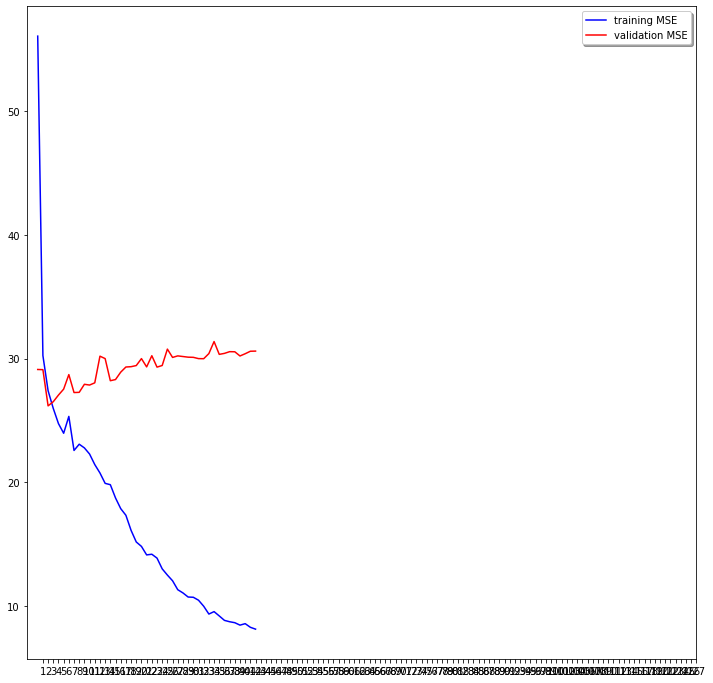

In [21]:
# Melakukan visualisasi nilai MSE pada data training dan testing.
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.plot(history.history['mse'], color='b', label = 'training MSE')
ax.plot(history.history['val_mse'], color='r', label = 'validation MSE')
ax.set_xticks(np.arange(1, epochs, 1))
legend = plt.legend(loc = 'best', shadow = True)
plt.show()

In [22]:
# Menyusun rekam jejak model berdasarkan nilai MSE pada setiap epoch, diurutkan dari yang terbaik.
history_df = pd.DataFrame(history.history).sort_values('val_mse').reset_index()
history_df.rename(columns = {'index': 'epoch'}, inplace = True)
history_df.to_csv('history_{}.csv'.format(codename), index = False)
history_df

,epoch,loss,mse,val_loss,val_mse,lr
0,2,27.415617,27.415213,26.190453,26.190039,0.003604
1,3,25.982101,25.981680,26.529543,26.529102,0.003604
2,4,24.757999,24.757547,27.064230,27.063753,0.003604
3,7,22.587107,22.586527,27.267977,27.267372,0.003604
4,8,23.092241,23.091618,27.285826,27.285179,0.003604
5,5,23.977095,23.976597,27.544479,27.543961,0.003604
6,10,22.296566,22.295824,27.874516,27.873734,0.003604
7,9,22.793512,22.792831,27.935377,27.934669,0.003604
8,11,21.446690,21.445894,28.054220,28.053406,0.001802
9,14,19.820576,19.819668,28.225061,28.224129,0.001802


In [23]:
# Menyimpan nilai prediksi validasi dan testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds = pd.DataFrame()
best_test_preds = pd.DataFrame()

for temp_index in list(history_df.iloc[:, 0]):
    temp_df_valid = pd.read_csv('./valid_preds_{}.csv'.format(temp_index))
    temp_df_test = pd.read_csv('./test_preds_{}.csv'.format(temp_index))
    best_valid_preds = pd.concat([best_valid_preds, temp_df_valid], axis = 1, ignore_index = True)
    best_test_preds = pd.concat([best_test_preds, temp_df_test], axis = 1, ignore_index = True)

best_valid_preds.to_csv('valid_preds_{}.csv'.format(codename), index = False)
best_test_preds.to_csv('test_preds_{}.csv'.format(codename), index = False)

In [24]:
# Membuang file yang sudah tidak diperlukan.
for temp_index in list(history_df.iloc[:, 0]):
    os.remove('./valid_preds_{}.csv'.format(temp_index))
    os.remove('./test_preds_{}.csv'.format(temp_index))

In [25]:
# Menampilkan prediksi data validasi diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,25.066225,24.918793,24.316340,26.541680,25.574040,25.075190,23.924046,26.557503,24.864698,24.640543,...,23.568680,23.337934,23.548744,23.649218,23.314445,23.423716,23.656054,23.511005,23.036709,22.930708
1,26.881943,26.665360,25.750557,26.472118,26.369308,25.991564,25.780123,27.836160,26.212800,26.600239,...,25.780460,25.825796,26.055346,25.845636,25.655659,25.927940,26.169203,26.132792,25.120922,25.097548
2,25.056345,24.926455,23.905330,24.790838,24.126595,24.582527,23.931602,24.978870,23.573774,23.693243,...,22.059622,21.983814,22.188707,22.069965,21.777473,21.888786,22.052097,21.765615,22.208870,21.352875
3,23.836480,24.391039,23.183790,23.227370,23.517310,23.332947,22.562720,24.591143,22.738777,22.753010,...,22.710230,22.780144,23.326603,22.764593,23.073020,23.046236,23.644520,23.424433,21.753176,21.886787
4,27.183617,27.146978,27.285295,27.628487,26.974306,26.878757,27.605259,29.074558,27.155638,28.075613,...,29.312082,29.787947,29.407133,29.234713,29.308916,29.363993,29.520390,29.517887,27.586807,28.661404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,23.361141,22.823730,22.372240,23.112087,23.381025,22.684406,23.735237,24.199877,23.201963,23.607325,...,24.320124,24.242195,24.833967,23.820210,23.825478,24.112854,24.487116,24.283459,23.469797,23.362719
457,23.648000,23.087670,21.871044,22.055040,22.456224,21.989058,21.904959,23.346016,21.274925,22.205040,...,22.692612,22.495106,23.198948,22.692577,22.540768,22.732187,22.725708,22.616137,22.774097,22.116735
458,24.877169,24.423199,24.054700,24.417046,24.226744,23.553774,24.821772,25.695887,23.814367,23.781538,...,23.460363,23.470697,23.777317,23.092993,23.429264,23.532207,23.824396,23.779310,22.911709,22.781553
459,25.818043,25.148209,24.498966,24.027033,23.525045,23.638090,23.271383,24.729195,22.853596,23.383774,...,23.409990,23.547293,23.531696,23.368343,23.310663,23.250082,23.658432,23.828903,22.340921,22.701435


In [26]:
# Menampilkan prediksi data testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_test_preds

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,25.046722,24.880568,25.408089,25.865208,24.607958,24.684143,23.714714,25.257723,23.909250,24.711859,...,22.942047,22.934944,23.225850,23.000048,22.701733,22.847687,22.956238,22.859430,22.461447,22.391277
1,26.820332,27.329538,26.085688,27.335402,26.900948,26.666023,25.902367,27.918760,26.256042,26.760046,...,25.118620,25.312092,25.259407,24.970633,24.916570,24.894380,25.091064,24.524633,24.313745,24.571362
2,26.404518,25.814974,25.833800,27.672333,27.048986,25.999866,27.334225,28.316988,27.304146,27.695858,...,28.615667,28.501050,28.902798,28.318588,28.313631,28.562454,28.775906,28.705750,26.892412,27.760454
3,28.454271,28.671846,28.129107,29.129759,28.449524,27.970129,28.845520,30.882956,28.860159,30.361692,...,30.767332,31.025780,31.013440,30.674220,30.490833,30.889800,31.415369,30.684217,29.582115,30.068295
4,28.236654,28.729807,28.036520,29.949581,28.493382,28.268976,28.609882,30.476395,29.438246,29.845919,...,28.274614,28.140884,28.709368,28.236652,27.862185,28.190653,27.976366,28.034640,28.116898,27.688896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,29.626627,28.609201,28.914095,30.723640,28.670475,28.303940,28.369800,30.873602,29.388065,29.643938,...,27.550259,27.437439,28.150370,27.327015,26.925766,27.142687,27.417791,27.136831,28.071230,26.890303
986,24.851566,23.479578,23.482533,24.440285,24.202217,23.087010,24.248196,25.801336,23.755978,25.189625,...,27.518948,27.606619,27.895765,27.436071,27.278236,27.352667,27.568275,27.698250,25.898380,26.941866
987,25.251234,25.030981,24.519314,25.994260,24.886562,25.345526,25.518387,27.142600,25.233513,26.157719,...,26.039730,26.152287,26.196365,25.930500,26.020378,26.066069,26.344800,25.879030,25.319017,25.366710
988,25.533180,25.953117,25.060223,26.310404,25.418081,24.844421,23.844840,26.594020,24.706617,24.345528,...,23.685820,23.767231,24.026810,23.770632,23.551998,23.764439,23.723919,23.646612,22.816685,23.086576


In [27]:
# Menampilkan nilai MSE terbaik pada data validasi.
error = MSE(y_valid, best_valid_preds[0])
print('nilai MSE pada data validasi: ', error)

nilai MSE pada data validasi:  26.19003715101544


In [28]:
# Mencatat waktu berakhirnya keseluruhan program model dan prediksi data.
global_end_time = time.time()

# Menampilkan waktu eksekusi dari keseluruhan program model dan prediksi data.
total_execution_time = datetime.timedelta(seconds = global_end_time - global_start_time)
print("total execution time: %s" % (total_execution_time))

total execution time: 0:13:48.686182
